Este script realiza um pipeline completo de análise quantitativa e predição de ativos financeiros. Ele começa importando bibliotecas de manipulação de dados, cálculo estatístico, indicadores técnicos e machine learning. Em seguida, baixa cotações históricas via yfinance, calcula retornos, médias móveis, indicadores do TA-Lib, bandas de Bollinger, estocástico, MACD, RSI, ADX, Hurst, entre muitos outros — totalizando dezenas de variáveis técnicas.

O código também aplica um filtro de volatilidade baseado na largura das Bandas de Bollinger, constrói sinais binários derivados de cruzamentos e condições dos indicadores e define janelas de treino e validação. Por fim, prepara variáveis alvo para modelos de classificação, permitindo treinar algoritmos como Naive Bayes para prever o comportamento futuro do ativo.

Em resumo, o script automatiza todo o processo de coleta de dados, construção de features técnicas, filtragem de mercado e preparação de targets para modelos de aprendizado de máquina aplicados ao mercado financeiro.

In [ ]:
###### Bibliotecas
import pandas as pd
import numpy as np
from hurst import compute_Hc, random_walk
import yfinance
from plotly.subplots import make_subplots
import plotly.graph_objects as go
# import kaleido # Removido se não for estritamente necessário para salvar imagens
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as metrics
import talib
import warnings
import matplotlib.pyplot as plt
import math
from scipy.stats import norm

Processando Ativo: AAPL


[*********************100%***********************]  1 of 1 completed


AVISO: Coluna 'Low_Volatility_Filter' não encontrada para AAPL. O filtro não será aplicado.


ANÁLISE DETALHADA DE TRADES (STATE-BASED) PARA: AAPL (Modelo 1 - GaussianNB)
Período: 2020-01-01 a 2025-11-11 | Custo: 0.05%




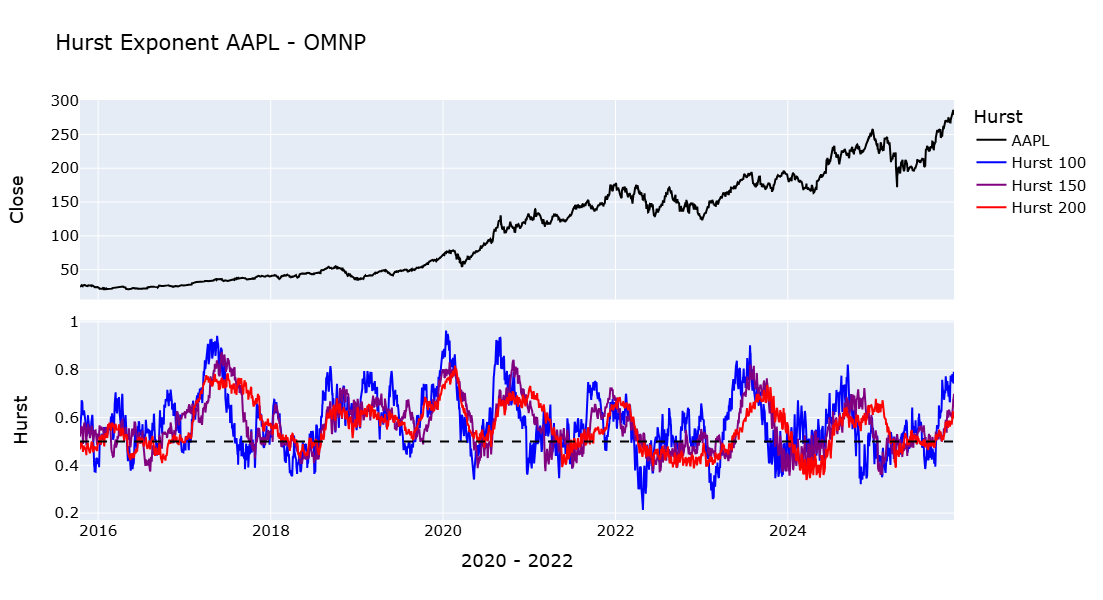

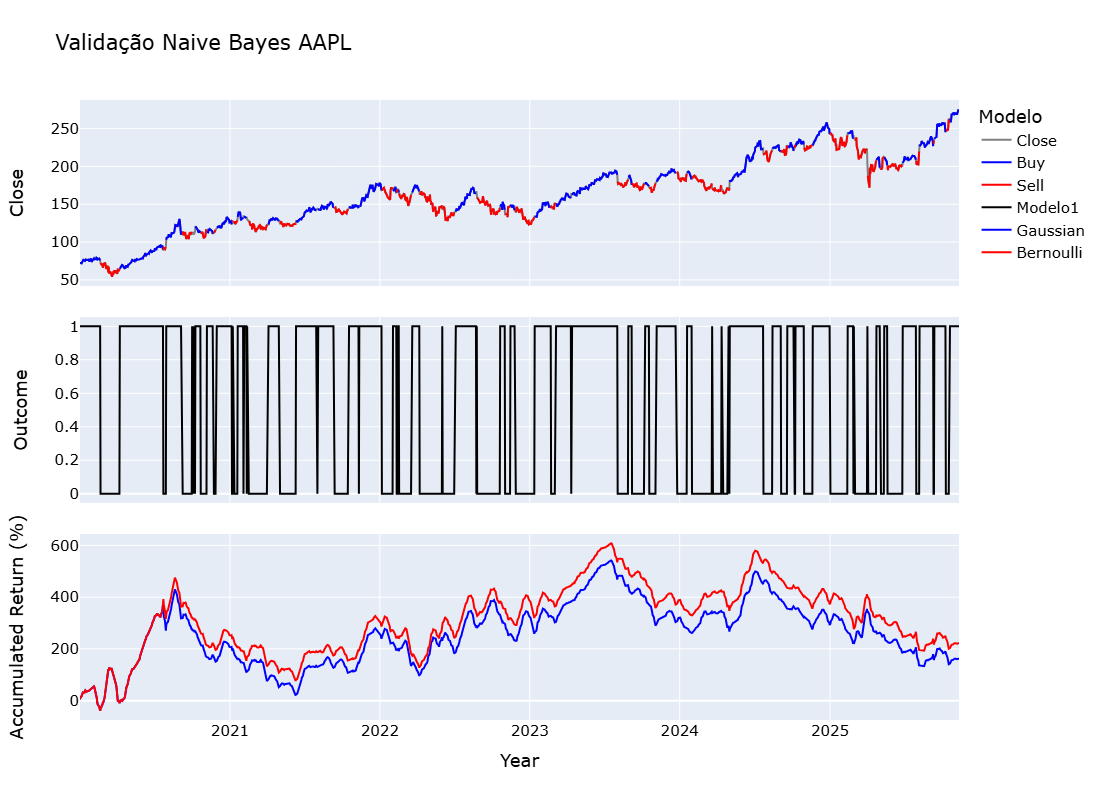

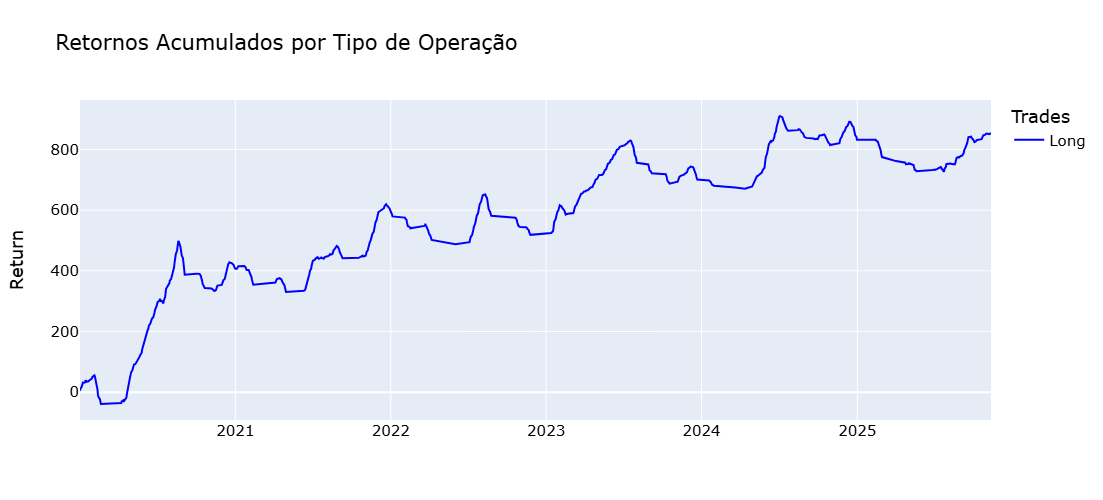


Soma dos Ganhos/Perdas (R$) apenas em operações de Compra (Long): 157.9295
 

Soma dos Retornos (%) apenas em operações de Compra (Long): 138.5352




In [2]:


warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
'''
['PETR4.SA', 'HBOR3.SA', 'AGRO3.SA', 'CIEL3.SA', 'CMIG4.SA', 'BOVA11.SA',
        'PETR4.SA', 'LIGT3.SA', 'MTRE3.SA', 'KLBN11.SA', 'BPAN4.SA', 'RDOR3.SA','SUZB3.SA',
        'EZTC3.SA', 'GOLL4.SA', 'ELET3.SA', 'EQTL3.SA', 'EGIE3.SA', 'QUAL3.SA', 'ENEV3.SA',
        'CSAN3.SA', 'VIVT3.SA', 'VBBR3.SA', 'BPAC11.SA', 'LREN3.SA', 'WEGE3.SA','CMIG3.SA',
        'HYPE3.SA', 'BBDC4.SA', 'BBDC3.SA', 'CYRE3.SA','AZUL4.SA', 'BHIA3.SA', 'STBP3.SA',
        'VALE3.SA', 'FLRY3.SA', 'CVCB3.SA','MEAL3.SA', 'ECOR3.SA', 'BBSE3.SA',
        'COGN3.SA', 'AMAR3.SA', 'ELET6.SA','PSSA3.SA', 'B3SA3.SA', 'HAPV3.SA',
        'PETZ3.SA','YDUQ3.SA', 'MULT3.SA', 'CRFB3.SA', 'RENT3.SA', 'CCRO3.SA', 'IRBR3.SA',
        'ITSA3.SA', 'TAEE11.SA', 'BBAS3.SA', 'ABEV3.SA', 'NTCO3.SA', 'ITUB3.SA', 'ARZZ3.SA',
        'EMBR3.SA', 'JBSS3.SA', 'GGBR4.SA', 'UGPA3.SA', 'RADL3.SA', 'SBSP3.SA', 'RAIL3.SA', 'PRIO3.SA',
        'AAPL', 'XOM','GE','IBM','MSFT', 'GOOGL', 'AMZN','GLD', 'SLV', 'USO', 'UNG', 'DBA','EURUSD=X', 'GBPUSD=X',
        'USDJPY=X','USDBRL=X', 'USDEUR=X', 'USDJPY=X','BRL=X','^BVSP','HASH11.SA']

stocks = ['PETR4.SA','MSFT','AAPL','AMZN','KLBN11.SA','ABEV3.SA']

'''
stocks = ['AAPL']
# stocks = ['PETR4.SA', 'HBOR3.SA', 'AGRO3.SA', 'CIEL3.SA', 'CMIG4.SA', 'BOVA11.SA']

# Função auxiliar para mostrar DataFrames no ambiente
def display(df):
    print(df.to_markdown(index=True, numalign="left", stralign="left"))


'''Looping lógico e filtros'''
for symbol in stocks:
    print(f"Processando Ativo: {symbol}")
    # Parametros e dataset
    start = "2015-01-01"
    
    # Baixando dados e garantindo acesso correto às colunas
    df0 = yfinance.download([symbol], start, interval = '1d')
    if df0.empty:
        print(f"Sem dados para {symbol}, pulando.")
        continue
        
    # CORREÇÃO: Acessando colunas como MultiIndex
    df0["Returns"] = df0[("Close", symbol)].pct_change(1)
    
    df0["Adj"] = df0[("Close", symbol)]
    df0["Adj Open"] = df0[("Open", symbol)]
    df0["Adj High"] = df0[("High", symbol)]
    df0["Adj Low"] = df0[("Low", symbol)]
    
    # DEFINIÇÃO DE INTERVALO DE TREINO E TESTE
    start_train = "2015-01-02"
    end_train = "2020-01-01"
    start_val = "2020-01-01"
    end_val = "2025-11-11"
    
    # EXPOENTE DE HURST
    hurst = lambda x: compute_Hc(x)[0]
    df0["hurst100"] = df0[("Close", symbol)].rolling(100).apply(hurst)
    df0["hurst150"] = df0[("Close", symbol)].rolling(150).apply(hurst)
    df0["hurst200"] = df0[("Close", symbol)].rolling(200).apply(hurst)
    
    # INDICADORES TÉCNICOS
    k = 10 # Período de look-ahead (dias de hold)

    # Médias aritméticas
    df0["SMA5"] = df0[("Close", symbol)].rolling(5).mean()
    df0["SMA10"] = df0[("Close", symbol)].rolling(10).mean()
    df0["SMA20"] = df0[("Close", symbol)].rolling(15).mean()
    df0["SMA50"] = df0[("Close", symbol)].rolling(20).mean()
    df0["SMA100"] = df0[("Close", symbol)].rolling(30).mean()
    
    # Médias exponenciais
    df0["EMA5"] = talib.EMA(df0[("Close", symbol)].values, timeperiod=5)
    df0["EMA10"] = talib.EMA(df0[("Close", symbol)].values, timeperiod=10)
    df0["EMA20"] = talib.EMA(df0[("Close", symbol)].values, timeperiod=15)
    df0["EMA50"] = talib.EMA(df0[("Close", symbol)].values, timeperiod=20)
    df0["EMA100"] = talib.EMA(df0[("Close", symbol)].values, timeperiod=30)
    
    df0["upperband"], df0["middleband"], df0["lowerband"] = talib.BBANDS(
        df0[("Close", symbol)].values,
        timeperiod=20,
        nbdevup=2,
        nbdevdn=2,
        matype=0)
    
    df0["bandwidth"] = df0["upperband"] - df0["lowerband"]
    
    df0["perc_b"] = (df0[("Close", symbol)].values - df0["lowerband"]) / df0["bandwidth"]

    # --- INÍCIO DA MODIFICAÇÃO 1: FILTRO DE VOLATILIDADE ---
    # Vamos usar a 'bandwidth' (Largura das Bandas de Bollinger de 20 dias) como métrica de volatilidade.
    # Vamos criar um filtro que é ativado (1) se a 'bandwidth' atual 
    # estiver 2 desvios padrões abaixo da sua média móvel (ex: 100 dias).
    
    vol_window = 20 # Janela para a média da volatilidade
    vol_std_devs = 10   # Número de desvios padrões
    
    df0["BW_Mean"] = df0["bandwidth"].rolling(vol_window).mean()
    df0["BW_Std"] = df0["bandwidth"].rolling(vol_window).std()
    
    # Limite inferior (Média - 2 Desvios)
    df0["BW_Lower_Band"] = df0["BW_Mean"] - (df0["BW_Std"] * vol_std_devs)
    
    # O filtro é 1 (ativo) se a volatilidade atual (bandwidth) estiver abaixo do limite
    df0["Low_Volatility_Filter"] = np.where(df0["bandwidth"] < df0["BW_Lower_Band"], 1, 0)
    # --- FIM DA MODIFICAÇÃO 1 ---

    df0["RSI5"] = talib.RSI(df0[("Close", symbol)].values, timeperiod=10)
    df0["RSI9"]  = talib.RSI(df0[("Close", symbol)].values, timeperiod=15)
    df0["RSI20"] = talib.RSI(df0[("Close", symbol)].values, timeperiod=20)

    df0["RSI5_lag"] = df0["RSI5"].shift(k)
    df0["RSI9_lag"] = df0["RSI9"].shift(k)
    df0["RSI20_lag"] = df0["RSI20"].shift(k)
    
    df0["MACD"], df0["macdsignal"], df0["macdhist"] = talib.MACD(df0[("Close", symbol)], fastperiod = 12, slowperiod = 26, signalperiod = 9)
    
    df0["slowk"], df0["slowd"] = talib.STOCH(df0["Adj High"], df0["Adj Low"], df0[("Close", symbol)], fastk_period = 5, slowk_period = 3, slowk_matype = 0
                                               , slowd_period = 3, slowd_matype = 0)
    
    df0["fastk"], df0["fastd"] = talib.STOCHF(df0["Adj High"], df0["Adj Low"], df0[("Close", symbol)], fastk_period = 5, fastd_period = 3, fastd_matype = 0)
    df0["William"] = talib.WILLR(df0["Adj High"], df0["Adj Low"], df0[("Close", symbol)], timeperiod = 10)
    
    df0["ADX"] = talib.ADX(df0["Adj High"], df0["Adj Low"] , df0[("Close", symbol)], timeperiod = 10)
    df0["PLUS_DI"] = talib.PLUS_DI(df0["Adj High"], df0["Adj Low"] , df0[("Close", symbol)], timeperiod = 10)
    df0["MINUS_DI"] = talib.MINUS_DI(df0["Adj High"], df0["Adj Low"] , df0[("Close", symbol)], timeperiod = 10)
    
    #Price and MACD Golden Cross and Dead Cross (2) # Vars 5-6
    df0["var1"] = np.where(((df0["macdhist"] > 0) & (df0["Returns"] > 0)),1 ,0)
    df0["var6"] = np.where(((df0["macdhist"] < 0) & (df0["Returns"] > 0)),1 ,0)
    
    #Price and Bollinger Band > 80 or <20 (2) # Vars 7-8
    df0["var7"] = np.where(((df0["perc_b"] > 0.8) & (df0["Returns"] > 0)),1 ,0)
    df0["var8"] = np.where(((df0["perc_b"] < 0.2) & (df0["Returns"] > 0)),1 ,0)
    
    # SMA Golden Cross and Dead Cross with volume of trading (60) # Vars 9-30
    df0["var9"] = np.where((df0["SMA5"] > df0["SMA10"]),1 ,0)
    df0["var10"] = np.where((df0["SMA5"] < df0["SMA10"]),1 ,0)
    df0["var11"] = np.where((df0["SMA5"] > df0["SMA20"]),1 ,0)
    df0["var12"] = np.where((df0["SMA5"] < df0["SMA20"]),1 ,0)
    df0["var13"] = np.where((df0["SMA5"] > df0["SMA50"]),1 ,0)
    df0["var14"] = np.where((df0["SMA5"] < df0["SMA50"]),1 ,0)
    df0["var15"] = np.where((df0["SMA5"] > df0["SMA100"]),1 ,0)
    df0["var16"] = np.where((df0["SMA5"] < df0["SMA100"]),1 ,0)
    
    df0["var17"] = np.where((df0["SMA10"] > df0["SMA20"]),1 ,0)
    df0["var18"] = np.where((df0["SMA10"] < df0["SMA20"]),1 ,0)
    df0["var19"] = np.where((df0["SMA10"] > df0["SMA50"]),1 ,0)
    df0["var20"] = np.where((df0["SMA10"] < df0["SMA50"]),1 ,0)
    df0["var21"] = np.where((df0["SMA10"] > df0["SMA100"]),1 ,0)
    df0["var22"] = np.where((df0["SMA10"] < df0["SMA100"]),1 ,0)
    
    df0["var23"] = np.where((df0["SMA20"] > df0["SMA50"]),1 ,0)
    df0["var24"] = np.where((df0["SMA20"] < df0["SMA50"]),1 ,0)
    df0["var25"] = np.where((df0["SMA20"] > df0["SMA100"]),1 ,0)
    df0["var26"] = np.where((df0["SMA20"] < df0["SMA100"]),1 ,0)
    
    df0["var29"] = np.where((df0["SMA50"] > df0["SMA100"]),1 ,0)
    df0["var30"] = np.where((df0["SMA50"] < df0["SMA100"]),1 ,0)
    
    # EMA Golden Cross and Dead Cross with volume of trading (60) # Vars 31-50
    df0["var31"] = np.where((df0["EMA5"] > df0["EMA10"]),1 ,0)
    df0["var32"] = np.where((df0["EMA5"] < df0["EMA10"]),1 ,0)
    df0["var33"] = np.where((df0["EMA5"] > df0["EMA20"]),1 ,0)
    df0["var34"] = np.where((df0["EMA5"] < df0["EMA20"]),1 ,0)
    df0["var35"] = np.where((df0["EMA5"] > df0["EMA50"]),1 ,0)
    df0["var36"] = np.where((df0["EMA5"] < df0["EMA50"]),1 ,0)
    df0["var37"] = np.where((df0["EMA5"] > df0["EMA100"]),1 ,0)
    df0["var38"] = np.where((df0["EMA5"] < df0["EMA100"]),1 ,0)
    
    df0["var39"] = np.where((df0["EMA10"] > df0["EMA20"]),1 ,0)
    df0["var40"] = np.where((df0["EMA10"] < df0["EMA20"]),1 ,0)
    df0["var41"] = np.where((df0["EMA10"] > df0["EMA50"]),1 ,0)
    df0["var42"] = np.where((df0["EMA10"] < df0["EMA50"]),1 ,0)
    df0["var43"] = np.where((df0["EMA10"] > df0["EMA100"]),1 ,0)
    df0["var44"] = np.where((df0["EMA10"] < df0["EMA100"]),1 ,0)
    
    df0["var45"] = np.where((df0["EMA20"] > df0["EMA50"]),1 ,0)
    df0["var46"] = np.where((df0["EMA20"] < df0["EMA50"]),1 ,0)
    df0["var47"] = np.where((df0["EMA20"] > df0["EMA100"]),1 ,0)
    df0["var48"] = np.where((df0["EMA20"] < df0["EMA100"]),1 ,0)

    
    df0["var49"] = np.where((df0["EMA50"] > df0["EMA100"]),1 ,0)
    df0["var50"] = np.where((df0["EMA50"] < df0["EMA100"]),1 ,0)
    
    # RSI >70 or < 30 (2) # Vars 53-58
    df0["var53"] = np.where( df0["RSI5"] > 55,1 ,0)
    df0["var54"] = np.where( df0["RSI5"] < 45,1 ,0)
    
    df0["var55"] = np.where( df0["RSI9"] > 55,1 ,0)
    df0["var56"] = np.where( df0["RSI9"] < 45,1 ,0)
    
    df0["var57"] = np.where( df0["RSI20"] > 55,1 ,0)
    df0["var58"] = np.where( df0["RSI20"] < 45,1 ,0)
    
    # RSI Golden Cross and Dead Cross (6) # Vars 59-64
    df0["var59"] = np.where(((df0["RSI5"] > df0["RSI9"])),1 ,0)
    df0["var60"] = np.where(((df0["RSI5"] < df0["RSI9"])),1 ,0)
    df0["var61"] = np.where(((df0["RSI5"] > df0["RSI20"])),1 ,0)
    df0["var62"] = np.where(((df0["RSI5"] < df0["RSI20"])),1 ,0)
    
    df0["var63"] = np.where(((df0["RSI9"] > df0["RSI20"])),1 ,0)
    df0["var64"] = np.where(((df0["RSI9"] < df0["RSI20"])),1 ,0)
    
    # Divergence of RSI and Price (6) # Vars 65-70
    df0["var65"] = np.where(((df0["RSI5"] > df0["RSI5_lag"]) & (df0["Returns"] > 0)),1 ,0)
    df0["var66"] = np.where(((df0["RSI5"] < df0["RSI5_lag"]) & (df0["Returns"] > 0)),1 ,0)
    
    df0["var67"] = np.where(((df0["RSI9"] > df0["RSI9_lag"]) & (df0["Returns"] > 0)),1 ,0)
    df0["var68"] = np.where(((df0["RSI9"] < df0["RSI9_lag"]) & (df0["Returns"] > 0)),1 ,0)
    
    df0["var69"] = np.where(((df0["RSI20"] > df0["RSI20_lag"]) & (df0["Returns"] > 0)),1 ,0)
    df0["var70"] = np.where(((df0["RSI20"] < df0["RSI20_lag"]) & (df0["Returns"] > 0)),1 ,0)
    
    # Stochastic Slow (K% D%)/Fast (K% D%)(4) # Vars 71-74
    df0["var71"] = np.where((df0["slowk"]/df0["fastk"]) > 1, 1, 0)
    df0["var72"] = np.where((df0["slowk"]/df0["fastd"]) > 1, 1, 0)
    df0["var73"] = np.where((df0["slowd"]/df0["fastk"]) > 1, 1, 0)
    df0["var74"] = np.where((df0["slowd"]/df0["fastd"]) > 1, 1, 0)
    
    # William % R > 80 or < 20 (2) # Vars 75-76
    df0["var75"] = np.where( df0["William"] > -20,1 ,0)
    df0["var76"] = np.where( df0["William"] < -80,1 ,0)
    
    # DI and ADX (4) # Vars 77-78
    df0["var77"] = np.where(((df0["PLUS_DI"] > df0["ADX"])),1 ,0)
    df0["var78"] = np.where(((df0["MINUS_DI"] > df0["ADX"])),1 ,0)
    
    # DI+ DI- # Vars 80
    df0["var80"] = np.where(((df0["PLUS_DI"] > df0["MINUS_DI"])),1 ,0)
    
    # Hurst # Vars 81-83
    df0["var81"] = np.where(((df0["hurst100"] > 0.5)),1 ,0)
    df0["var82"] = np.where(((df0["hurst150"] > 0.5)),1 ,0)
    df0["var83"] = np.where(((df0["hurst200"] > 0.5)),1 ,0)
    
    df0 = df0.dropna(axis = 0)  
    if df0.empty:
        print(f"Sem dados após o dropna para {symbol}, pulando.")
        continue
        
    # CALCULO ALVO
    # Alvo Binário
    df0["Alvo_Bin"] = np.where(df0["SMA10"].shift(-k)>df0["SMA50"].shift(-k), 1, 0)
    # Alvo Percentual (Retorno % nos próximos k dias)
    df0["Alvo"] = (df0[("Close", symbol)].shift(-k)/df0[("Close", symbol)]-1)*100

    # Adiciona a coluna de Preço de Saída (Close price k dias à frente)
    df0["Future_Close_Price"] = df0[("Close", symbol)].shift(-k)

    # CORREÇÃO: Reintroduzindo o achatamento das colunas
    df0.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in df0.columns]
    
    # CORREÇÃO: Usando os nomes achatados com "_"
    # Criando o nome da coluna dinamicamente
    close_col_name = f"Close_{symbol}"
    
    # Garantir que as colunas existam após o achatamento e obter os nomes corretos
    col_close = [c for c in df0.columns if c.startswith("Close_")][0] if [c for c in df0.columns if c.startswith("Close_")] else 'Close'
    col_alvo_bin = [c for c in df0.columns if c.startswith("Alvo_Bin_")][0] if [c for c in df0.columns if c.startswith("Alvo_Bin_")] else 'Alvo_Bin'
    col_alvo = [c for c in df0.columns if c.startswith("Alvo_") and not c.startswith("Alvo_Bin_")][0] if [c for c in df0.columns if c.startswith("Alvo_") and not c.startswith("Alvo_Bin_")] else 'Alvo'
    col_adj = [c for c in df0.columns if c.startswith("Adj_")][0] if [c for c in df0.columns if c.startswith("Adj_")] else 'Adj'
    
    # O nome da coluna Future_Close_Price (sem o sufixo _PETR4.SA)
    col_future_close = "Future_Close_Price"
    
    # Se por acaso o achatamento adicionou o sufixo para esta coluna (como aconteceu), pegamos o nome correto
    if f"{col_future_close}_" in df0.columns:
        col_future_close = f"{col_future_close}_"

    # TREINAMENTO E TESTE
    df0_dev = df0.loc[start_train : end_train].copy()
    df0_val = df0.loc[start_val : end_val].copy()

    if df0_dev.empty or df0_val.empty:
        print(f"Não há dados suficientes nos períodos de treino/validação para {symbol}, pulando.")
        continue

    # CORREÇÃO: Usando os nomes achatados com "_"
    # Nota: Assumindo que as colunas var1_ a var83_ existem e estão corretamente achatadas.
    X = df0_dev.loc[:, "var1_":"var83_"]
    y = df0_dev[col_alvo_bin]
    
    X_val = df0_val.loc[:, "var1_":"var83_"]
    y_val = df0_val[col_alvo_bin]
    
    X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.70, random_state = 42)
    
    model1 = GaussianNB(var_smoothing = 0.01)
    model2 = BernoulliNB(fit_prior = False, alpha = 0.01)
    
    # TREINO
    model1.fit(X_train, y_train)
    model2.fit(X_train, y_train)
    
    # PREDICT
    fit_val1 = model1.predict(X_val)
    fit_val2 = model2.predict(X_val)
    
    # Seleciona colunas para avaliação
    colunas_desejadas = [
        "Close", "Alvo", "Alvo_Bin", "var9", 
        "SMA5", "SMA10", "SMA20", "SMA50", 
        "RSI9", "RSI20", "hurst100", "hurst150", "hurst200"]
    
    # Filtra colunas achatadas
    colunas_achatadas_desejadas = [c for c in df0_val.columns if c.split('_')[0] in colunas_desejadas]
    
    # Seleciona só as colunas que existem no DataFrame
    colunas_existentes = [c for c in colunas_achatadas_desejadas if c in df0_val.columns]
    
    # Garante que as colunas de preço e alvo essenciais estejam presentes
    # CORREÇÃO: Garantir que não haja colunas duplicadas na criação do df_avaliacao
    colunas_base = [col_close, col_alvo, col_future_close]
    colunas_complementares = [c for c in colunas_existentes if c not in colunas_base]
    # Usa a lista de colunas base + as complementares únicas
    df_avaliacao = df0_val[colunas_base + colunas_complementares].copy()  
    
    df_avaliacao["Modelo1"] = fit_val1
    df_avaliacao["Modelo2"] = fit_val2
    
    # --- INÍCIO DA MODIFICAÇÃO 2: ADICIONAR FILTRO AO DF DE AVALIAÇÃO ---
    # (Os nomes das colunas de filtro não são tuplas, então não são achatados com '_')
    if "Low_Volatility_Filter" in df0_val.columns:
        df_avaliacao["Low_Vol_Filter"] = df0_val["Low_Volatility_Filter"]
    else:
        print(f"AVISO: Coluna 'Low_Volatility_Filter' não encontrada para {symbol}. O filtro não será aplicado.")
        df_avaliacao["Low_Vol_Filter"] = 0 # Desativa o filtro se não for encontrado
    # --- FIM DA MODIFICAÇÃO 2 ---
    
    custo = 0.05 # Custo de transação (em percentual, 0.05%)
    
    # Calcula retorno do modelo (Retorno Percentual já com custo)
    df_avaliacao["Ret_Modelo1"] = np.where(
        (df_avaliacao["Modelo1"] == 1),  
        df0_val[col_alvo] - custo,
        np.where(
            (df_avaliacao["Modelo1"] == 0),
            -df0_val[col_alvo] - custo,
            0
        )
    )

    df_avaliacao["Ret_Modelo2"] = np.where(
        (df_avaliacao["Modelo2"] == 1),  
        df0_val[col_alvo] - custo,
        np.where(
            (df_avaliacao["Modelo2"] == 0),
            -df0_val[col_alvo] - custo,
            0
        )
    )

    df_avaliacao["Acc_Modelo1"] = df_avaliacao["Ret_Modelo1"].cumsum(axis = 0)
    df_avaliacao["Acc_Modelo2"] = df_avaliacao["Ret_Modelo2"].cumsum(axis = 0)
    
    # -------------------------------------------------------------
    # GERAÇÃO DO DATAFRAME DE ANÁLISE DE TRADES (LÓGICA STATE-BASED)
    # --- INÍCIO DA MODIFICAÇÃO 3 (LÓGICA "FICAR NEUTRO") ---
    # -------------------------------------------------------------
    print("\n\n" + "="*80)
    print(f"ANÁLISE DETALHADA DE TRADES (STATE-BASED) PARA: {symbol} (Modelo 1 - GaussianNB)")
    print(f"Período: {start_val} a {end_val} | Custo: {custo:.2f}%")
    print("="*80)

    trades_list = []
    position = 0 # 0 = Flat, 1 = Long, -1 = Short
    entry_date = None
    entry_price = 0.0

    # Adiciona a coluna de preço de fechamento ao df_avaliacao para facilitar a iteração
    df_avaliacao['Close_Price'] = df0_val[col_close]

    # Iteramos pelas linhas do dataframe de avaliação
    for date, row in df_avaliacao.iterrows():
        signal = row['Modelo1']
        current_price = row['Close_Price']
        is_low_vol = row['Low_Vol_Filter'] == 1

        # --- NOVA LÓGICA DE TARGET POSITION ---
        # 1. Determina a posição alvo (target_position)
        if is_low_vol:
            # Se a volatilidade é baixa, FORÇA a posição NEUTRA (0).
            target_position = 0
        else:
            # Se a volatilidade é normal, usa o sinal do modelo.
            target_position = 1 if signal == 1 else -1
        # --- FIM DA NOVA LÓGICA ---

        # 2. Compara a posição atual (position) com a posição alvo (target_position)

        # Caso 1: Estamos NEUTROS (position == 0)
        if position == 0:
            if target_position != 0: # E o alvo é entrar (Long ou Short)
                # Abrir a nova posição
                position = target_position
                entry_date = date
                entry_price = current_price
            # else: (target_position == 0): Estamos neutros e o alvo é neutro. Nada a fazer.
        
        # Caso 2: Estamos POSICIONADOS (position != 0)
        elif position != 0:
            if position != target_position:
                # Se a posição atual é diferente do alvo, DEVE FECHAR a posição.
                # Isso acontece em duas situações:
                # 1. Reversão (Long -> Short ou Short -> Long)
                # 2. Saída para Neutro (Long -> 0 ou Short -> 0)
                
                # 1. Fechar a posição anterior
                exit_date = date
                exit_price = current_price
                
                trade_type = 'Compra (Long)' if position == 1 else 'Venda (Short)'
                
                if position == 1: # Fechando Long
                    pnl_real_bruto = exit_price - entry_price
                    pnl_pct_bruto = (exit_price / entry_price - 1) * 100
                else: # Fechando Short (Invertemos P&L)
                    pnl_real_bruto = entry_price - exit_price
                    pnl_pct_bruto = (entry_price / exit_price - 1) * 100
                
                # Aplicar custos
                pnl_pct_liquido = pnl_pct_bruto - custo
                custo_real = (entry_price * (custo / 100))
                pnl_real_liquido = pnl_real_bruto - custo_real

                trades_list.append([
                    trade_type,
                    entry_date,
                    exit_date,
                    entry_price,
                    exit_price,
                    pnl_real_liquido,
                    pnl_pct_liquido
                ])
                
                # 2. Abrir a nova posição (APENAS se o alvo não for Neutro)
                if target_position != 0:
                    position = target_position
                    entry_date = date
                    entry_price = current_price
                else:
                    # Se o alvo é Neutro, zeramos os controles
                    position = 0
                    entry_date = None
                    entry_price = 0.0
            
            # else: (position == target_position): Alvo é manter a posição. Nada a fazer.
    
    # --- FIM DA MODIFICAÇÃO 3 ---
    
    # Se o loop terminar e ainda estivermos em uma posição, fechamos na última data
    if position != 0:
        exit_date = df_avaliacao.index[-1]
        exit_price = df_avaliacao['Close_Price'].iloc[-1]
        
        trade_type = 'Compra (Long)' if position == 1 else 'Venda (Short)'
        
        if position == 1: # Fechando Long
            pnl_real_bruto = exit_price - entry_price
            pnl_pct_bruto = (exit_price / entry_price - 1) * 100
        else: # Fechando Short
            pnl_real_bruto = entry_price - exit_price
            pnl_pct_bruto = (entry_price / exit_price - 1) * 100
            
        pnl_pct_liquido = pnl_pct_bruto - custo
        custo_real = (entry_price * (custo / 100))
        pnl_real_liquido = pnl_real_bruto - custo_real

        trades_list.append([
            trade_type,
            entry_date,
            exit_date,
            entry_price,
            exit_price,
            pnl_real_liquido,
            pnl_pct_liquido
        ])

    # Criar o DataFrame final
    df_analise_trades = pd.DataFrame(
        trades_list,
        columns=[
            'Tipo_de_Operacao',
            'Dia_de_Compra',
            'Dia_de_Venda',
            'Preco_de_Compra',
            'Preco_de_Venda',
            'Diferenca_Ganho_Perda_R$',
            'Retorno_Percentual_Liquido'
        ]
    ).round(4)
    
    # 4. Printar (display) o resultado
    #display(df_analise_trades)
    
    print("\n" + "="*80 + "\n")

    # PLOTS (MANTIDOS)
    fig = make_subplots(rows = 2, cols = 1, shared_xaxes = True, vertical_spacing = 0.05)
    fig.add_trace(go.Scatter(x = df0.index, y = df0[col_close], name = symbol, line = dict(color = "black")), row = 1, col = 1)
    fig.add_trace(go.Scatter(x = df0.index, y = df0["hurst100_"], name = "Hurst 100", line = dict(color = "blue")), row = 2, col = 1)
    fig.add_trace(go.Scatter(x = df0.index, y = df0["hurst150_"], name = "Hurst 150", line = dict(color = "purple")), row = 2, col = 1)
    fig.add_trace(go.Scatter(x = df0.index, y = df0["hurst200_"], name = "Hurst 200", line = dict(color = "red")), row = 2, col = 1)
    fig.add_hline(y = 0.5, line_width = 2, line_dash = "dash", line_color = "black", row = 2, col = 1)
    fig.update_layout(height = 600, width = 800, title_text = f"Hurst Exponent {symbol} - OMNP", font_color = "blue", title_font_color = "black", xaxis2_title = "2020 - 2022", yaxis_title = "Close", yaxis2_title = "Hurst", showlegend = True, legend_title = "Hurst", font = dict(size = 15, color = "Black"))
    fig.show()
    
    # PLOT RESULTADOS
    fig = make_subplots(rows = 3, cols = 1, shared_xaxes = True, vertical_spacing = 0.05)
    fig.add_trace(go.Scatter(x = df_avaliacao.index, y = np.round(df0_val[col_close].shift(-1), 2), name = "Close", line = dict(color = "gray")), row = 1, col = 1)
    fig.add_trace(go.Scatter(x = df_avaliacao.index, y = np.where(df_avaliacao["Modelo1"] == 1, df0_val[col_close].shift(-1), None), name = "Buy", line = dict(color = "blue")), row = 1, col = 1)
    fig.add_trace(go.Scatter(x = df_avaliacao.index, y = np.where(df_avaliacao["Modelo1"] == 0, df0_val[col_close].shift(-1), None), name = "Sell", line = dict(color = "red")), row = 1, col = 1)
    fig.add_trace(go.Scatter(x = df_avaliacao.index, y = np.round(df_avaliacao["Modelo1"], 2), name = "Modelo1", line = dict(color = "black")), row = 2, col = 1)
    fig.add_trace(go.Scatter(x = df_avaliacao.index, y = np.round(df_avaliacao["Acc_Modelo1"], 2), name = "Gaussian", line = dict(color = "blue")), row = 3, col = 1)
    
    # --- INÍCIO DA CORREÇÃO DO SYNTAXERROR ---
    fig.add_trace(go.Scatter(x = df_avaliacao.index, y = np.round(df_avaliacao["Acc_Modelo2"], 2), name = "Bernoulli", line = dict(color = "red")), row=3, col=1)
    # --- FIM DA CORREÇÃO DO SYNTAXERROR ---
    
    fig.update_layout(height=800, width=800, title_text=f"Validação Naive Bayes {symbol}", font_color="blue", title_font_color="black",xaxis3_title="Year", yaxis_title="Close", yaxis2_title="Outcome", yaxis3_title="Accumulated Return (%)",showlegend=True, legend_title="Modelo", font=dict(size=15, color="Black"))
    fig.show()

    mascara_compra = df_avaliacao['Modelo1'] == 1
    mascara_venda = df_avaliacao['Modelo1'] == 0
    valores_compra_modelo1 = df_avaliacao.loc[mascara_compra, 'Ret_Modelo1']
    valores_venda_modelo1 = df_avaliacao.loc[mascara_venda, 'Ret_Modelo1']
    compra_plot = valores_compra_modelo1.cumsum(axis = 0)
    venda_plot = valores_venda_modelo1.cumsum(axis = 0)
    
    # PLOT RESULTADOS buy/sell
    fig = make_subplots(rows = 1, cols = 1, shared_xaxes = True, vertical_spacing = 0.05)
    fig.add_trace(go.Scatter(x = compra_plot.index, y = np.round(compra_plot, 2), name = "Long", line = dict(color = "blue")), row = 1, col = 1)
    #fig.add_trace(go.Scatter(x = venda_plot.index, y = np.round(venda_plot, 2), name = "Short", line = dict(color = "red")), row = 1, col = 1)
    fig.update_layout(height=500, width=800, title_text="Retornos Acumulados por Tipo de Operação", font_color="blue", title_font_color="black",yaxis_title="Return", showlegend=True,legend_title="Trades", font=dict(size=15, color="Black"))
    fig.show()

    # NOVO PRINT SOLICITADO: Soma dos ganhos/perdas apenas das posições de Compra (Long)
    soma_ganho_perda_compra = df_analise_trades[
        df_analise_trades['Tipo_de_Operacao'] == 'Compra (Long)'
    ]['Diferenca_Ganho_Perda_R$'].sum()

    soma_perc_compra = df_analise_trades[
        df_analise_trades['Tipo_de_Operacao'] == 'Compra (Long)'
    ]['Retorno_Percentual_Liquido'].sum()
    
    print(f"\nSoma dos Ganhos/Perdas (R$) apenas em operações de Compra (Long): {soma_ganho_perda_compra:.4f}")
    print(' ')
    print(f"\nSoma dos Retornos (%) apenas em operações de Compra (Long): {soma_perc_compra:.4f}")
    
    print("\n" + "="*80 + "\n")
